In [1]:
import matplotlib
matplotlib.use("Agg")

In [2]:
import matplotlib.pyplot as plt
from mozaik.storage.datastore import PickledDataStore
from parameters import ParameterSet
from mozaik.storage.queries import *
import sys
%matplotlib inline
import logging
import scipy
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [99]:
import sys
import os
t_res, s_res, array_width = 5, 50, 4000
radii = [50,100,150,200,250]
n_trials = 30

module_path = "/home/rozsa/dev/spontaneous_paper_experiments/paper_repo/mozaik-models/Rozsa_Cagnol2024"
if module_path not in sys.path:
    sys.path.append(module_path)
from msa_analysis_plotting import *

def retrieve_ds_param_values(dsv, param_name):
    # Hacky function because of DataStore limitations
    # Retrieves all direct stimulation parameter values from dsv
    l=[]
    for s in dsv.get_stimuli():
        if MozaikParametrized.idd(s).direct_stimulation_parameters != None:
            l.append(MozaikParametrized.idd(s).direct_stimulation_parameters.stimulating_signal_parameters[param_name])
    return sorted(list(set(l)))

def interpolate_2d(arr, target_shape):
    # Create a grid of coordinates for the input array
    N, M = arr.shape
    x_sparse, y_sparse = np.meshgrid(np.arange(M), np.arange(N))

    # Flatten the input array and coordinates
    x_sparse_flat = x_sparse.ravel()
    y_sparse_flat = y_sparse.ravel()
    arr_flat = arr.ravel()

    # Create a grid of coordinates for the target shape
    target_N, target_M = target_shape
    x_dense, y_dense = np.meshgrid(np.linspace(0, M-1, target_M), np.linspace(0, N-1, target_N))

    # Perform 2D interpolation using griddata
    z_dense_interpolated = scipy.interpolate.griddata((x_sparse_flat, y_sparse_flat), arr_flat, (x_dense, y_dense), method='linear')

    return z_dense_interpolated

def radial_mean(image, num_annuli):
    min_im_size = min(image.shape)
    image = image[image.shape[0]//2-min_im_size//2:image.shape[0]//2+min_im_size//2, image.shape[1]//2-min_im_size//2:image.shape[1]//2+min_im_size//2]
    if min_im_size // 2 != num_annuli:
        image = interpolate_2d(image, (num_annuli * 2,num_annuli * 2))
    center_x, center_y = num_annuli, num_annuli
    radius, angle = np.meshgrid(np.arange(num_annuli*2) - center_x, np.arange(num_annuli*2) - center_y, indexing='ij')
    radius = np.sqrt(radius**2 + angle**2)
    
    annulus_radii = np.linspace(0, num_annuli, num_annuli + 1)
    
    # Compute the average magnitude within each annulus
    radial_mean = np.zeros(num_annuli)
    for i in range(num_annuli):
        mask = (radius >= annulus_radii[i]) & (radius < annulus_radii[i + 1])
        radial_mean[i] = np.mean(np.abs(image[mask]))
    return radial_mean

def gaussian_smooth(x, y, x_eval, sigma):
    """Smooth y values at x_eval using Gaussian kernel smoothing."""
    smoothed_mean = np.zeros_like(x_eval)
    smoothed_se = np.zeros_like(x_eval)

    for i, xe in enumerate(x_eval):
        weights = scipy.stats.norm.pdf(x, loc=xe, scale=sigma)  # Gaussian weights
        weights /= weights.sum()  # Normalize weights
        smoothed_mean[i] = np.sum(weights * y)
        smoothed_se[i] = np.sqrt(np.sum(weights * (y - smoothed_mean[i])**2)) / np.sqrt(weights.sum())
    
    return smoothed_mean, smoothed_se

def get_current_profiles(dsv, r_fine):
    ids = dsv.get_analysis_result()[0].ids
    A = np.array(dsv.get_analysis_result()[0].asl).squeeze()
    r = np.sqrt(np.sum(dsv.get_neuron_positions()["V1_Exc_L2/3"][:2,dsv.get_sheet_indexes("V1_Exc_L2/3", ids)] ** 2,axis=0))
    r_sort_idx = np.argsort(r)
    return np.array([gaussian_smooth(r[r_sort_idx], A[:,i][r_sort_idx], r_fine, 0.005) for i in range(A.shape[1])])

In [24]:
paths_morph_1 = [
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250117-173530[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250120-144244[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250120-144250[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250120-144255[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250120-144301[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
]
paths_morph_2 = [
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250119-162430[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250120-145004[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250120-145010[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250120-145015[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250120-145020[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
    ]

paths_no_morph = [
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250120-213934[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250121-154310[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250121-154314[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250121-154319[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
    "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250121-154324[param_spont.defaults]CombinationParamSearch{trial:[0]}/SelfSustainedPushPull_ParameterSearch_____trial:0",
]

paths_noconn_morph_1 = [
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214359[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214404[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214409[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214414[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214419[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
]

paths_noconn_morph_2 = [
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214426[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214431[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214436[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214440[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214445[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
]

paths_noconn_no_morph = [
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214312[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214317[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214322[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214327[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
    '/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/20250127-214331[param_spont.defaults]CombinationParamSearch{11}/SelfSustainedPushPull_ParameterSearch_____base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_base_weight:0_store_stimuli:True',
]

ds_morph_1 = [
    PickledDataStore(
        load=True,
        parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),
        replace=False,
    ) for path in paths_morph_1
]

ds_morph_2 = [
    PickledDataStore(
        load=True,
        parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),
        replace=False,
    ) for path in paths_morph_2
]

ds_no_morph = [
    PickledDataStore(
        load=True,
        parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),
        replace=False,
    ) for path in paths_no_morph
]

ds_noconn_morph_1 = [
    PickledDataStore(
        load=True,
        parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),
        replace=False,
    ) for path in paths_noconn_morph_1
]

ds_noconn_morph_2 = [
    PickledDataStore(
        load=True,
        parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),
        replace=False,
    ) for path in paths_noconn_morph_2
]

ds_noconn_no_morph = [
    PickledDataStore(
        load=True,
        parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),
        replace=False,
    ) for path in paths_noconn_no_morph
]
if 0:
    for ds in ds_no_morph + ds_morph_1 + ds_morph_2 + ds_noconn_morph_1 + ds_noconn_morph_2 + ds_noconn_no_morph:
        ds.remove_ads_from_datastore()
        RecordingArrayTimecourse(param_filter_query(ds,sheet_name="V1_Exc_L2/3"),
            ParameterSet(
                {
                    "s_res": s_res,
                    "t_res": t_res,
                    "array_width": array_width,
                    "electrode_radius": 50,
                }
            ),
        ).analyse()
        ds.save()

# radii x trials x time x space x space
A_morph_1 = np.array([[np.array(param_filter_query(ds.full_datastore,st_trial=j,st_name='InternalStimulus').get_analysis_result()[0].analog_signal) for j in range(n_trials)] for ds in ds_morph_1])
radial_means_morph_1 = np.array([[radial_mean(A_morph_1[i,:,j,:,:].mean(axis=0), array_width // s_res) for j in range(A_morph_1.shape[2])]for i in range(A_morph_1.shape[0])])
#A_morph_2 = np.array([[np.array(param_filter_query(ds.full_datastore,st_trial=j,st_name='InternalStimulus').get_analysis_result()[0].analog_signal) for j in range(n_trials)] for ds in ds_morph_2])
#radial_means_morph_2 = np.array([[radial_mean(A_morph_2[i,:,j,:,:].mean(axis=0), array_width // s_res) for j in range(A_morph_2.shape[2])]for i in range(A_morph_2.shape[0])])
#A_no_morph = np.array([[np.array(param_filter_query(ds.full_datastore,st_trial=j,st_name='InternalStimulus').get_analysis_result()[0].analog_signal) for j in range(n_trials)] for ds in ds_no_morph])
#radial_means_no_morph = np.array([[radial_mean(A_no_morph[i,:,j,:,:].mean(axis=0), array_width // s_res) for j in range(A_no_morph.shape[2])]for i in range(A_no_morph.shape[0])])

#A_noconn_morph_1 = np.array([[np.array(param_filter_query(ds.full_datastore,st_trial=j,st_name='InternalStimulus').get_analysis_result()[0].analog_signal) for j in range(n_trials)] for ds in ds_noconn_morph_1])
#radial_means_noconn_morph_1 = np.array([[radial_mean(A_noconn_morph_1[i,:,j,:,:].mean(axis=0), array_width // s_res) for j in range(A_noconn_morph_1.shape[2])]for i in range(A_noconn_morph_1.shape[0])])
#A_noconn_morph_2 = np.array([[np.array(param_filter_query(ds.full_datastore,st_trial=j,st_name='InternalStimulus').get_analysis_result()[0].analog_signal) for j in range(n_trials)] for ds in ds_noconn_morph_2])
#radial_means_noconn_morph_2 = np.array([[radial_mean(A_noconn_morph_2[i,:,j,:,:].mean(axis=0), array_width // s_res) for j in range(A_noconn_morph_2.shape[2])]for i in range(A_noconn_morph_2.shape[0])])
#A_noconn_no_morph = np.array([[np.array(param_filter_query(ds.full_datastore,st_trial=j,st_name='InternalStimulus').get_analysis_result()[0].analog_signal) for j in range(n_trials)] for ds in ds_noconn_no_morph])
#radial_means_noconn_no_morph = np.array([[radial_mean(A_noconn_no_morph[i,:,j,:,:].mean(axis=0), array_width // s_res) for j in range(A_noconn_no_morph.shape[2])]for i in range(A_noconn_no_morph.shape[0])])

import matplotlib.pyplot as plt
import numpy as np

names = ["Morphology 1", "Morphology 2", "No morphology"]
radii = [50, 100, 150, 200, 250]
rmm = [radial_means_morph_1,radial_means_morph_2,radial_means_no_morph]
rmm_noconn = [radial_means_noconn_morph_1,radial_means_noconn_morph_2,radial_means_noconn_no_morph]

def plot_across_morphologies(radial_means_morph_1, radial_means_morph_2, radial_means_no_morph,plus_title=""):
    # Create Figure 1: Subplots for each radius
    fig1, axs1 = plt.subplots(1, len(radii), figsize=(20, 5), sharey=True)
    fig1.suptitle("Mean and SEM by Radius" + plus_title, fontsize=16)
    
    x = np.linspace(0, 2, array_width // s_res)
    for i, radius in enumerate(radii):
        ax = axs1[i]
        ax.set_title(f"Radius={radius}um")
        
        # Morphology 1
        y1 = radial_means_morph_1[i, :100 // t_res, :].mean(axis=0)
        sem1 = radial_means_morph_1[i, :100 // t_res, :].std(axis=0) / np.sqrt(radial_means_morph_1[i, :100 // t_res, :].shape[0])
        ax.plot(x, y1, label=names[0])
        ax.fill_between(x, y1 - sem1, y1 + sem1, alpha=0.3)
        
        # Morphology 2
        y2 = radial_means_morph_2[i, :100 // t_res, :].mean(axis=0)
        sem2 = radial_means_morph_2[i, :100 // t_res, :].std(axis=0) / np.sqrt(radial_means_morph_2[i, :100 // t_res, :].shape[0])
        ax.plot(x, y2, label=names[1])
        ax.fill_between(x, y2 - sem2, y2 + sem2, alpha=0.3)
        
        # No morphology
        y3 = radial_means_no_morph[i, :100 // t_res, :].mean(axis=0)
        sem3 = radial_means_no_morph[i, :100 // t_res, :].std(axis=0) / np.sqrt(radial_means_no_morph[i, :100 // t_res, :].shape[0])
        ax.plot(x, y3, label=names[2])
        ax.fill_between(x, y3 - sem3, y3 + sem3, alpha=0.3)
        
        ax.set_xlabel("Distance from center (mm)")
        if i == 0:
            ax.set_ylabel("Firing rate (sp/s)")
        ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
    plt.show()

def plot_across_radii(rmm,plus_title=""):
    # Create Figure 2: Subplots for each morphology
    fig2, axs2 = plt.subplots(1, len(names), figsize=(15, 5), sharey=True)
    fig2.suptitle("Mean and SEM by Morphology" + plus_title, fontsize=16)
    
    for i, name in enumerate(names):
        ax = axs2[i]
        ax.set_title(name)
        x = np.linspace(0, 2, array_width // s_res)
        for j, radius in enumerate(radii):
            y = rmm[i][j, :100 // t_res, :].mean(axis=0)
            sem = rmm[i][j, :100 // t_res, :].std(axis=0) / np.sqrt(rmm[i][j, :100 // t_res, :].shape[0])
            ax.plot(x, y, label=f"Radius={radius}um")
            ax.fill_between(x, y - sem, y + sem, alpha=0.3)
        
        ax.set_xlabel("Distance from center (mm)")
        if i == 0:
            ax.set_ylabel("Firing rate (sp/s)")
        ax.legend(title="Radius")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
    plt.show()
    
#plot_across_morphologies(radial_means_morph_1, radial_means_morph_2, radial_means_no_morph)
#plot_across_radii(rmm)
#plot_across_morphologies(radial_means_noconn_morph_1, radial_means_noconn_morph_2, radial_means_noconn_no_morph,"\nNo connections")
#plot_across_radii(rmm_noconn,"\nNo connections")

NameError: name 'radial_means_morph_2' is not defined

## No connections run analyses

In [10]:
import os
base_dir = "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/"
m1_base_path = "20250131-180233[param_spont.defaults]CombinationParamSearch{12}"
m2_base_path = "20250131-180238[param_spont.defaults]CombinationParamSearch{12}"
no_m_base_path = "20250131-180244[param_spont.defaults]CombinationParamSearch{12}"

get_full_datastore_paths = lambda base_path : sorted([os.path.join(base_dir,base_path,path) for path in os.listdir(os.path.join(base_dir,base_path)) if os.path.isdir(os.path.join(base_dir,base_path,path))])
get_datastores = lambda paths : [PickledDataStore(load=True,parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),replace=False) for path in paths]

#ds_noconn_morph_1 = get_datastores(get_full_datastore_paths(m1_base_path))
#ds_noconn_morph_2 = get_datastores(get_full_datastore_paths(m2_base_path))
#ds_noconn_morph_no_morph = get_datastores(get_full_datastore_paths(no_m_base_path))

In [57]:
A_noconn_morph_1 = np.array([[np.array(param_filter_query(ds.full_datastore,st_trial=j,st_name='InternalStimulus',analysis_algorithm='RecordingArrayTimecourse').get_analysis_result()[0].analog_signal) for j in range(n_trials)] for ds in ds_noconn_morph_1])
radial_means_noconn_morph_1 = np.array([[radial_mean(A_noconn_morph_1[i,:,j,:,:].mean(axis=0), array_width // s_res) for j in range(A_noconn_morph_1.shape[2])]for i in range(A_noconn_morph_1.shape[0])])
A_noconn_morph_2 = np.array([[np.array(param_filter_query(ds.full_datastore,st_trial=j,st_name='InternalStimulus',analysis_algorithm='RecordingArrayTimecourse').get_analysis_result()[0].analog_signal) for j in range(n_trials)] for ds in ds_noconn_morph_2])
radial_means_noconn_morph_2 = np.array([[radial_mean(A_noconn_morph_2[i,:,j,:,:].mean(axis=0), array_width // s_res) for j in range(A_noconn_morph_2.shape[2])]for i in range(A_noconn_morph_2.shape[0])])
A_noconn_no_morph = np.array([[np.array(param_filter_query(ds.full_datastore,st_trial=j,st_name='InternalStimulus',analysis_algorithm='RecordingArrayTimecourse').get_analysis_result()[0].analog_signal) for j in range(n_trials)] for ds in ds_noconn_no_morph])
radial_means_noconn_no_morph = np.array([[radial_mean(A_noconn_no_morph[i,:,j,:,:].mean(axis=0), array_width // s_res) for j in range(A_noconn_no_morph.shape[2])]for i in range(A_noconn_no_morph.shape[0])])

In [58]:
%matplotlib inline
rmm_noconn = [radial_means_noconn_morph_1,radial_means_noconn_morph_2,radial_means_noconn_no_morph]
plot_across_morphologies(radial_means_noconn_morph_1, radial_means_noconn_morph_2, radial_means_noconn_no_morph,"\nNo connections")
plot_across_radii(rmm_noconn,"\nNo connections")

NameError: name 'plot_across_morphologies' is not defined

In [59]:
# radii x time x (mean,std) x radial distance
r_fine = np.linspace(0.01, 0.5, 300)  # Fine grid for smoothness
I_m1 = np.array([get_current_profiles(param_filter_query(ds.full_datastore,y_axis_name='optical_stimulation_current'),r_fine) for ds in ds_noconn_morph_1])
I_m2 = np.array([get_current_profiles(param_filter_query(ds.full_datastore,y_axis_name='optical_stimulation_current'),r_fine) for ds in ds_noconn_morph_2])
I_no_morph = np.array([get_current_profiles(param_filter_query(ds.full_datastore,y_axis_name='optical_stimulation_current'),r_fine) for ds in ds_noconn_morph_no_morph])
# input current in nA

In [106]:
print([retrieve_ds_param_values(ds, "intensity")[0] for ds in ds_noconn_morph_1])

[0.2, 0.05, 0.0222, 0.0125, 0.008]


In [148]:
print(A_morph_1.shape)
# radii x trials x time x space x space
#radial_means_morph_1 = np.array([[[radial_mean(A_morph_1[i,j,k,:,:]., array_width // s_res) for k in range(A_morph_1.shape[2])] for j in range(A_morph_1.shape[1])]for i in range(A_morph_1.shape[0])])
radial_means_morph_1_mean = np.array([[radial_mean(A_morph_1[i,:,k,:,:].mean(axis=0), array_width // s_res) for k in range(A_morph_1.shape[2])] for i in range(A_morph_1.shape[0])])
radial_means_morph_1_sem = np.array([[radial_mean(A_morph_1[i,:,k,:,:].std(axis=0) / np.sqrt(n_trials), array_width // s_res) for k in range(A_morph_1.shape[2])] for i in range(A_morph_1.shape[0])])
radial_means_morph_2_mean = np.array([[radial_mean(A_morph_2[i,:,k,:,:].mean(axis=0), array_width // s_res) for k in range(A_morph_1.shape[2])] for i in range(A_morph_1.shape[0])])
radial_means_morph_2_sem = np.array([[radial_mean(A_morph_2[i,:,k,:,:].std(axis=0) / np.sqrt(n_trials), array_width // s_res) for k in range(A_morph_1.shape[2])] for i in range(A_morph_1.shape[0])])
radial_means_no_morph_mean = np.array([[radial_mean(A_no_morph[i,:,k,:,:].mean(axis=0), array_width // s_res) for k in range(A_morph_1.shape[2])] for i in range(A_morph_1.shape[0])])
radial_means_no_morph_sem = np.array([[radial_mean(A_no_morph[i,:,k,:,:].std(axis=0) / np.sqrt(n_trials), array_width // s_res) for k in range(A_morph_1.shape[2])] for i in range(A_morph_1.shape[0])])

(5, 30, 30, 80, 80)


In [149]:
print(radial_means_morph_1_mean.shape)

(5, 30, 80)


In [8]:
if 1:
    fig,ax = plt.subplots(1,3,figsize=(14,3))
    plt.subplots_adjust(wspace=0.3)
    plot_fr(radial_means_morph_1_mean,radial_means_morph_1_sem,ax[0],"Morphology 1")
    plot_fr(radial_means_morph_2_mean,radial_means_morph_2_sem,ax[1],"Morphology 2")
    plot_fr(radial_means_no_morph_mean,radial_means_no_morph_sem,ax[2],"No morphology")
    plt.show()

data_basic_fr = {
    "morph_1" : {"radial_means_mean" : radial_means_morph_1_mean, "radial_means_sem" : radial_means_morph_1_sem},
    "morph_2" : {"radial_means_mean" : radial_means_morph_2_mean, "radial_means_sem" : radial_means_morph_2_sem},
    "no_morph" : {"radial_means_mean" : radial_means_no_morph_mean, "radial_means_sem" : radial_means_no_morph_sem},
}
plot_fr_across_morphs(data_basic_fr,radii)

NameError: name 'radial_means_morph_1_mean' is not defined

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1400x300 -pix_fmt rgba -r 4.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y fr_video.mp4


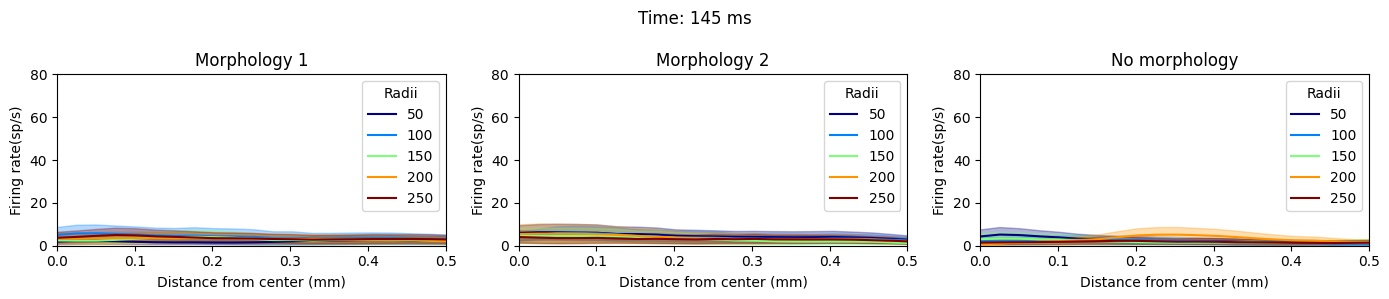

In [162]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def plot_fr_video(mean,sem,ax,title=""):
    x = np.linspace(0, 2, array_width // s_res)
    colors = [plt.get_cmap("jet")(i / (len(radii) - 1)) for i in range(len(radii))]
    
    # Initial plot setup
    I_mean, I_sem = [mean[i, 0, :] for i in range(len(radii))], [sem[i, 0, :] for i in range(len(radii))]
    lines = [ax.plot(x, I_mean[i], color=colors[i])[0] for i in range(len(radii))]
    fill_betweens = [ax.fill_between(x, I_mean[i] - I_sem[i], I_mean[i] + I_sem[i], alpha=0.3, label="_nolegend_", color=colors[i]) for i in range(len(radii))]
    
    ax.set_title(title)
    ax.set_xlabel("Distance from center (mm)")
    ax.set_ylabel("Firing rate(sp/s)")
    ax.set_xlim(0, 0.5)
    ax.set_ylim(0,80)
    ax.legend(labels=radii, title="Radii")
    
    def update(frame):
        for i in range(len(radii)):
            I_mean, I_sem = mean[i, frame, :], sem[i, frame, :]
            lines[i].set_ydata(I_mean)
            fill_betweens[i].remove()
            fill_betweens[i] = ax.fill_between(x, I_mean - I_sem, I_mean + I_sem, alpha=0.3, label="_nolegend_", color=colors[i])

        return lines + [b for b in fill_betweens]
    
    return update, lines, fill_betweens

# Create the figure and subplots
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
plt.subplots_adjust(wspace=0.3)

# Initialize the animations

anim1 = plot_fr_video(radial_means_morph_1_mean,radial_means_morph_1_sem,ax[0],"Morphology 1")
anim2 = plot_fr_video(radial_means_morph_2_mean,radial_means_morph_2_sem,ax[1],"Morphology 2")
anim3 = plot_fr_video(radial_means_no_morph_mean,radial_means_no_morph_sem,ax[2],"No morphology")

# Define the update function that updates all subplots in parallel
def update_all(frame):
    color = 'red' if frame < 100 // t_res else 'black'
    fig.suptitle(f"Time: {frame * t_res} ms",color=color)#,y=1.05,fontsize=14)
    anim1[0](frame)
    anim2[0](frame)
    anim3[0](frame)
    return (anim1[1] + [b for b in anim1[2]]) + \
           (anim2[1] + [b for b in anim2[2]]) + \
           (anim3[1] + [b for b in anim3[2]])

# Create the animation
anim = FuncAnimation(fig, update_all, frames=radial_means_morph_1_mean.shape[1], interval=50 * t_res, blit=True)
plt.tight_layout()
# To save the animation as a video file, use:
anim.save('fr_video.mp4', writer='ffmpeg')
plt.show()

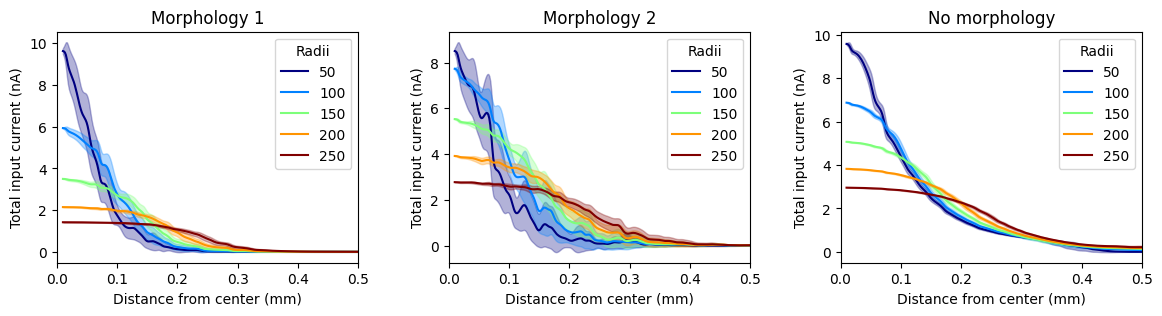

In [66]:
def plot_I(I,ax,title=""):
    colors = [plt.get_cmap("jet")(i / (len(radii) - 1)) for i in range(len(radii))]
    for i in range(len(radii)):
        I_mean, I_sem = I[i,:,0,:].sum(axis=0), I[i,:,1,:].sum(axis=0)
        ax.plot(r_fine,I_mean,color=colors[i])
        ax.fill_between(r_fine, I_mean - I_sem, I_mean + I_sem, 
                         alpha=0.3, label="_nolegend_",color=colors[i])
    ax.set_title(title)
    ax.set_xlabel("Distance from center (mm)")
    ax.set_ylabel("Total input current (nA)")
    ax.set_xlim(0,0.5)
    ax.legend(labels=radii,title="Radii")

fig,ax = plt.subplots(1,3,figsize=(14,3))
plt.subplots_adjust(wspace=0.3)
plot_I(I_m1,ax[0],"Morphology 1")
plot_I(I_m2,ax[1],"Morphology 2")
plot_I(I_no_morph,ax[2],"No morphology")
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def plot_I_video(I, ax, title=""):
    colors = [plt.get_cmap("jet")(i / (len(radii) - 1)) for i in range(len(radii))]
    
    # Initial plot setup
    I_mean, I_sem = [I[i, 0, 0, :] for i in range(len(radii))], [I[i, 0, 1, :] for i in range(len(radii))]
    lines = [ax.plot(r_fine, I_mean[i], color=colors[i])[0] for i in range(len(radii))]
    fill_betweens = [ax.fill_between(r_fine, I_mean[i] - I_sem[i], I_mean[i] + I_sem[i], alpha=0.3, label="_nolegend_", color=colors[i]) for i in range(len(radii))]
    
    ax.set_title(title)
    ax.set_xlabel("Distance from center (mm)")
    ax.set_ylabel("Total input current (nA)")
    ax.set_xlim(0, 0.5)
    ax.set_ylim(0,0.1)
    ax.legend(labels=radii, title="Radii")
    
    def update(frame):
        for i in range(len(radii)):
            I_mean, I_sem = I[i, frame, 0, :], I[i, frame, 1, :]
            lines[i].set_ydata(I_mean)
            fill_betweens[i].remove()
            fill_betweens[i] = ax.fill_between(r_fine, I_mean - I_sem, I_mean + I_sem, alpha=0.3, label="_nolegend_", color=colors[i])

        return lines + [b for b in fill_betweens]
    
    return update, lines, fill_betweens

# Create the figure and subplots
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
plt.subplots_adjust(wspace=0.3)

# Initialize the animations
anim1 = plot_I_video(I_m1, ax[0], "Morphology 1")
anim2 = plot_I_video(I_m2, ax[1], "Morphology 2")
anim3 = plot_I_video(I_no_morph, ax[2], "No morphology")

# Define the update function that updates all subplots in parallel
def update_all(frame):
    color = 'red' if frame < 100 else 'black'
    fig.suptitle(f"Time: {frame} ms",color=color)#,y=1.05,fontsize=14)
    anim1[0](frame)
    anim2[0](frame)
    anim3[0](frame)
    return (anim1[1] + [b for b in anim1[2]]) + \
           (anim2[1] + [b for b in anim2[2]]) + \
           (anim3[1] + [b for b in anim3[2]])

# Create the animation
anim = FuncAnimation(fig, update_all, frames=I_m1.shape[1], interval=50, blit=True)
plt.tight_layout()
# To save the animation as a video file, use:
anim.save('combined_video.mp4', writer='ffmpeg')
plt.show()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1400x300 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y combined_video.mp4


## Same max firing rate analysis

In [244]:
m1_base_path = "20250228-173427[param_spont.defaults]CombinationParamSearch{trial:[0, 1, 2]}"
m2_base_path = "20250228-173433[param_spont.defaults]CombinationParamSearch{trial:[0, 1, 2]}"
no_m_base_path = "20250325-150208[param_spont.defaults]CombinationParamSearch{trial:[0, 1, 2]}"


get_full_datastore_paths = lambda base_path : sorted([os.path.join(base_dir,base_path,path) for path in os.listdir(os.path.join(base_dir,base_path)) if os.path.isdir(os.path.join(base_dir,base_path,path))])
get_datastores = lambda paths : [PickledDataStore(load=True,parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),replace=False) for path in paths]

ds_same_fr = {}
ds_same_fr["morph_1"] = get_datastores(get_full_datastore_paths(m1_base_path))
ds_same_fr["morph_2"] = get_datastores(get_full_datastore_paths(m2_base_path))
ds_same_fr["no_morph"] = get_datastores(get_full_datastore_paths(no_m_base_path))

In [176]:
from msa_analysis_plotting import *

for key in data_same_fr.keys():
    for ds in ds_same_fr[key]:
        #ds.remove_ads_from_datastore()
        #RecordingArrayTimecourse(queries.param_filter_query(ds,sheet_name="V1_Exc_L2/3"),
        #    ParameterSet(
        #        {
        #            "s_res": 50,
        #            "t_res": 1,
        #            "array_width": 4000,
        #            "electrode_radius": 50, 
        #        }
        #    ),
        #).analyse()
        ds.save()

In [245]:
print([retrieve_ds_param_values(ds, "intensity")[0] for ds in ds_same_fr["no_morph"]])

[1.6, 0.4, 0.299]


In [246]:
t_res = 1
data_same_fr = {k: {} for k in ds_same_fr.keys()}
for key in data_same_fr.keys():
    data_same_fr[key]["A"] = np.array([[np.array(param_filter_query(ds.full_datastore,st_trial=j,st_name='InternalStimulus',analysis_algorithm='RecordingArrayTimecourse').get_analysis_result()[0].analog_signal) for j in range(n_trials)] for ds in ds_same_fr[key]])
    data_same_fr[key]["radial_means_mean"] = np.array([[radial_mean(data_same_fr[key]["A"][i,:,k,:,:].mean(axis=0), array_width // s_res) for k in range(data_same_fr[key]["A"].shape[2])] for i in range(data_same_fr[key]["A"].shape[0])])

In [247]:
data_same_fr["morph_1"]["A"].shape

(3, 30, 150, 80, 80)

In [248]:
for key in data_same_fr.keys():
    # First SEM and then radial mean
    #data_same_fr[key]["radial_means_sem"] = np.array([radial_mean(data_same_fr[key]["A"][i,:,:100//t_res,:,:].mean(axis=1).std(axis=0) / np.sqrt(n_trials), array_width // s_res) for i in range(data_same_fr[key]["A"].shape[0])])
    # First radial mean and then SEM
    data_same_fr[key]["radial_means_sem"] = np.array([[radial_mean(data_same_fr[key]["A"][i,t,:,:,:].mean(axis=1), array_width // s_res) for i in range(data_same_fr[key]["A"].shape[0])] for t in range(n_trials)]).std(axis=0) / np.sqrt(n_trials)
    print(data_same_fr[key]["radial_means_sem"].shape)

(3, 80)
(3, 80)
(3, 80)


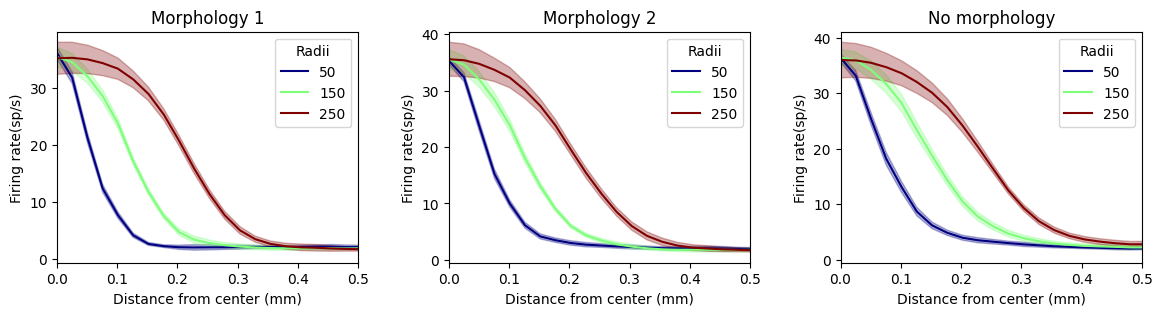

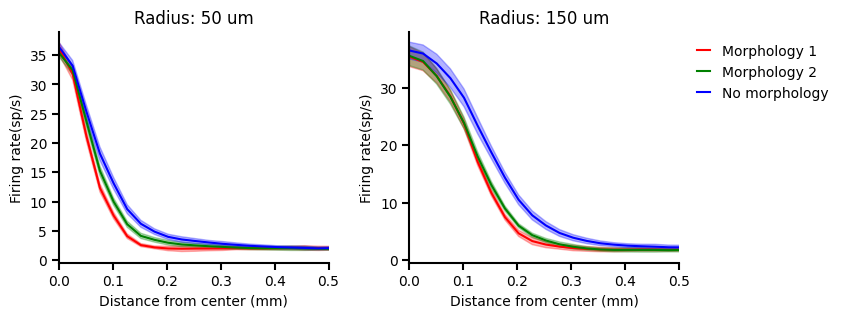

In [249]:
%matplotlib inline

def plot_fr(mean,sem,ax,title="",radii=[50,100,150,200,250]):
    colors = [plt.get_cmap("jet")(i / (len(radii) - 1)) for i in range(len(radii))]
    x = np.linspace(0, 2, array_width // s_res)
    for i in range(len(radii)):
        I_mean, I_sem = mean[i, :100 // t_res, :].mean(axis=0), sem[i, :]
        ax.plot(x,I_mean,color=colors[i])
        ax.fill_between(x, I_mean - I_sem, I_mean + I_sem, 
                         alpha=0.3, label="_nolegend_",color=colors[i])
    ax.set_title(title)
    ax.set_xlabel("Distance from center (mm)")
    ax.set_ylabel("Firing rate(sp/s)")
    ax.set_xlim(0,0.5)
    ax.legend(labels=radii,title="Radii")

def plot_fr_across_morphs(data_dict,radii=[50,100,150,200,250]):
    fig,ax = plt.subplots(1,len(radii),figsize=(2+3*len(radii),3))
    plt.subplots_adjust(wspace=0.3)
    x = np.linspace(0, 2, array_width // s_res)
    names = ["morph_1","morph_2","no_morph"]
    #colors = [plt.get_cmap("jet")(i / (len(radii) - 1)) for i in range(len(radii))]
    colors = ["r","g","b"]
    for i in range(len(radii)):
        for j in range(3):
            mean, sem = data_dict[names[j]]["radial_means_mean"][i, :100 // t_res, :].mean(axis=0), data_dict[names[j]]["radial_means_sem"][i, :]
            ax[i].plot(x,mean,color=colors[j])
            ax[i].fill_between(x, mean - sem, mean + sem, 
                             alpha=0.3, label="_nolegend_",color=colors[j])
        #ax[i].legend(labels=["Morphology 1","Morphology 2","No morphology"])
        ax[i].set_title(f"Radius: {radii[i]} um")
        ax[i].set_xlabel("Distance from center (mm)")
        ax[i].set_ylabel("Firing rate(sp/s)")
        ax[i].set_xlim(0,0.5)

        ax[i].spines[['top','right']].set_visible(False)
        ax[i].spines[['left','bottom']].set_linewidth(1.5)
        ax[i].tick_params(size=5, width=1.5)
    ax[-1].legend(labels=["Morphology 1","Morphology 2","No morphology"],bbox_to_anchor=(1.6, 1.0),handlelength=1,frameon=False)
    plt.show()

fig,ax = plt.subplots(1,3,figsize=(14,3))
plt.subplots_adjust(wspace=0.3)
plot_fr(data_same_fr["morph_1"]["radial_means_mean"],data_same_fr["morph_1"]["radial_means_sem"],ax[0],"Morphology 1",radii=[50,150,250])
plot_fr(data_same_fr["morph_2"]["radial_means_mean"],data_same_fr["morph_2"]["radial_means_sem"],ax[1],"Morphology 2",radii=[50,150,250])
plot_fr(data_same_fr["no_morph"]["radial_means_mean"],data_same_fr["no_morph"]["radial_means_sem"],ax[2],"No morphology",radii=[50,150,250])
plt.show()

plot_fr_across_morphs(data_same_fr,radii=[50,150])

In [177]:
print(data_same_fr["morph_1"]["radial_means_mean"].shape)
print(data_I_same_fr["morph_1"]["radial_means_mean"].shape)

(3, 150, 80)
(3, 150, 250)


In [250]:
for name, d in zip(["current","fr"],[data_I_same_fr,data_same_fr]):
    for k in d:
        np.save(f"{k}_{name}_mean.npy",d[k]["radial_means_mean"])
        np.save(f"{k}_{name}_sem.npy",d[k]["radial_means_sem"])

In [251]:
print(f"{k}_{name}_sem.npy")

no_morph_fr_sem.npy


In [77]:
same_fr_current_m1_base_path = "20250307-190602[param_spont.defaults]CombinationParamSearch{12}"
same_fr_current_m2_base_path = "20250307-190608[param_spont.defaults]CombinationParamSearch{12}"
same_fr_current_no_morph_base_path = "20250325-150335[param_spont.defaults]CombinationParamSearch{12}"

ds_same_fr_noconn = {}
ds_same_fr_noconn["morph_1"] = get_datastores(get_full_datastore_paths(same_fr_current_m1_base_path))
ds_same_fr_noconn["morph_2"] = get_datastores(get_full_datastore_paths(same_fr_current_m2_base_path))
ds_same_fr_noconn["no_morph"] = get_datastores(get_full_datastore_paths(same_fr_current_no_morph_base_path))

(671, 150)
(671,)
(443, 150)
(443,)
(857, 150)
(857,)


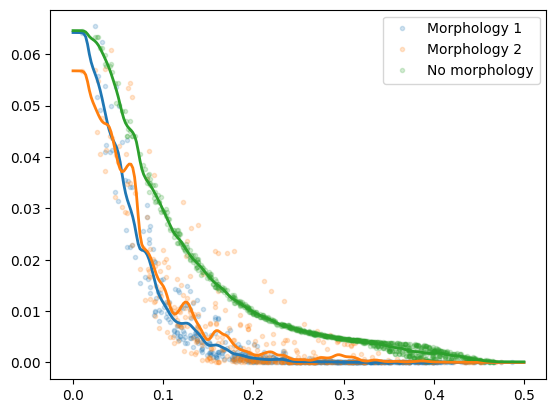

(37500, 150)
(37500,)
(6811, 150)
(6811,)
(37500, 150)
(37500,)


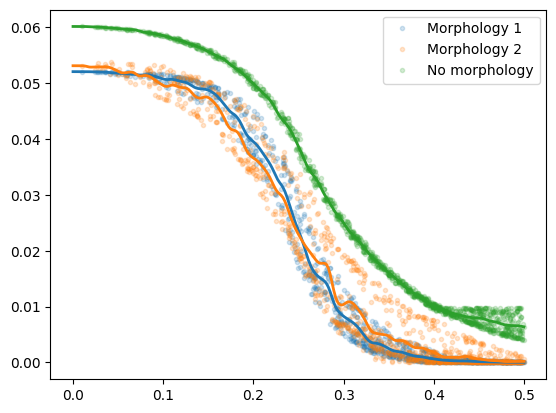

In [256]:
def get_current_profiles(dsv, r_fine,name):
    ids = dsv.get_analysis_result()[0].ids
    A = np.array(dsv.get_analysis_result()[0].asl).squeeze()
    r = np.sqrt(np.sum(dsv.get_neuron_positions()["V1_Exc_L2/3"][:2,dsv.get_sheet_indexes("V1_Exc_L2/3", ids)] ** 2,axis=0))
    print(A.shape)
    print(r.shape)
    r_sort_idx = np.argsort(r)
    r = r[r_sort_idx]
    A = A[r_sort_idx,:]
    #print(r)
    r = r[r<0.5]
    A = A[:len(r),:]
    plt.plot(r,A.mean(axis=1),'.',alpha=0.2)
    np.save(f"r_{name}.npy",r)
    np.save(f"current_{name}.npy",A)
    return np.array([gaussian_smooth(r, A[:,i], r_fine, 0.005) for i in range(A.shape[1])])

m1_prof = get_current_profiles(param_filter_query(ds_same_fr_noconn["morph_1"][0].full_datastore,y_axis_name='optical_stimulation_current'), r_fine,"50_morph_1")
m2_prof = get_current_profiles(param_filter_query(ds_same_fr_noconn["morph_2"][0].full_datastore,y_axis_name='optical_stimulation_current'), r_fine,"50_morph_2")
nm_prof = get_current_profiles(param_filter_query(ds_same_fr_noconn["no_morph"][0].full_datastore,y_axis_name='optical_stimulation_current'), r_fine,"50_no_morph")
plt.plot(r_fine,m1_prof.mean(axis=0)[0],c='tab:blue',lw=2)
plt.plot(r_fine,m2_prof.mean(axis=0)[0],c='tab:orange',lw=2)
plt.plot(r_fine,nm_prof.mean(axis=0)[0],c='tab:green',lw=2)
plt.legend(["Morphology 1","Morphology 2","No morphology"])
plt.show()

m1_prof = get_current_profiles(param_filter_query(ds_same_fr_noconn["morph_1"][2].full_datastore,y_axis_name='optical_stimulation_current'), r_fine,"150_morph_1")
m2_prof = get_current_profiles(param_filter_query(ds_same_fr_noconn["morph_2"][2].full_datastore,y_axis_name='optical_stimulation_current'), r_fine,"150_morph_2")
nm_prof = get_current_profiles(param_filter_query(ds_same_fr_noconn["no_morph"][2].full_datastore,y_axis_name='optical_stimulation_current'), r_fine,"150_no_morph")
plt.plot(r_fine,m1_prof.mean(axis=0)[0],c='tab:blue',lw=2)
plt.plot(r_fine,m2_prof.mean(axis=0)[0],c='tab:orange',lw=2)
plt.plot(r_fine,nm_prof.mean(axis=0)[0],c='tab:green',lw=2)
plt.legend(["Morphology 1","Morphology 2","No morphology"])
plt.show()

In [160]:
# radii x time x (mean,std) x radial distance
r_fine = np.linspace(0, 0.5, 250)  # Fine grid for smoothness

I_m1 = np.array([get_current_profiles(param_filter_query(ds.full_datastore,y_axis_name='optical_stimulation_current'),r_fine) for ds in ds_same_fr_noconn["morph_1"]])
I_m2 = np.array([get_current_profiles(param_filter_query(ds.full_datastore,y_axis_name='optical_stimulation_current'),r_fine) for ds in ds_same_fr_noconn["morph_2"]])
I_no_morph = np.array([get_current_profiles(param_filter_query(ds.full_datastore,y_axis_name='optical_stimulation_current'),r_fine) for ds in ds_same_fr_noconn["no_morph"]])
# input current in nA

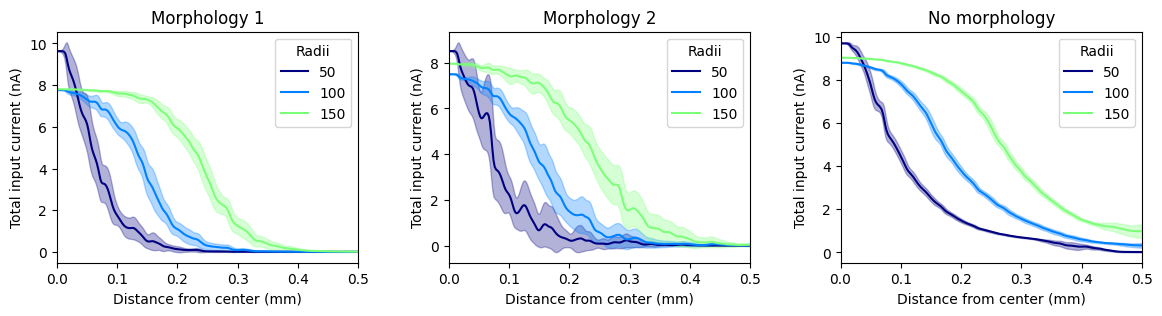

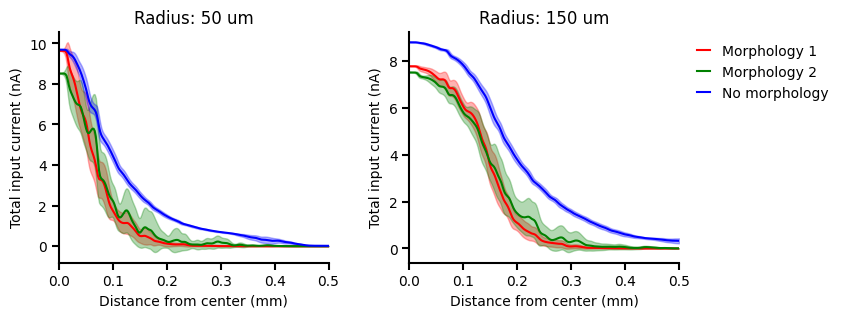

In [161]:
def plot_I(I,ax,title=""):
    colors = [plt.get_cmap("jet")(i / (len(radii) - 1)) for i in range(len(radii))]
    for i in range(len([50,100,150])):
        I_mean, I_sem = I[i,:,0,:].sum(axis=0), I[i,:,1,:].sum(axis=0)
        ax.plot(r_fine,I_mean,color=colors[i])
        ax.fill_between(r_fine, I_mean - I_sem, I_mean + I_sem, 
                         alpha=0.3, label="_nolegend_",color=colors[i])
    ax.set_title(title)
    ax.set_xlabel("Distance from center (mm)")
    ax.set_ylabel("Total input current (nA)")
    ax.set_xlim(0,0.5)
    ax.legend(labels=[50,100,150],title="Radii")

fig,ax = plt.subplots(1,3,figsize=(14,3))
plt.subplots_adjust(wspace=0.3)
plot_I(I_m1,ax[0],"Morphology 1")
plot_I(I_m2,ax[1],"Morphology 2")
plot_I(I_no_morph,ax[2],"No morphology")
plt.show()

def plot_I_across_morphs(data_dict,x,radii=[50,150,250]):
    fig,ax = plt.subplots(1,len(radii),figsize=(2+3*len(radii),3))
    plt.subplots_adjust(wspace=0.3)
    names = ["morph_1","morph_2","no_morph"]
    #colors = [plt.get_cmap("jet")(i / (len(radii) - 1)) for i in range(len(radii))]
    colors = ["r","g","b"]
    for i in range(len(radii)):
        for j in range(3):
            mean, sem = data_dict[names[j]]["radial_means_mean"][i, :, :].sum(axis=0), data_dict[names[j]]["radial_means_sem"][i, :, :].sum(axis=0)
            ax[i].plot(x,mean,color=colors[j],lw=1.5)
            ax[i].fill_between(x, mean - sem, mean + sem, 
                             alpha=0.3, label="_nolegend_",color=colors[j])
        
        ax[i].set_title(f"Radius: {radii[i]} um")
        ax[i].set_xlabel("Distance from center (mm)")
        ax[i].set_ylabel("Total input current (nA)")
        ax[i].set_xlim(0,0.5)

        ax[i].spines[['top','right']].set_visible(False)
        ax[i].spines[['left','bottom']].set_linewidth(1.5)
        ax[i].tick_params(size=5, width=1.5)
    ax[-1].legend(labels=["Morphology 1","Morphology 2","No morphology"],bbox_to_anchor=(1.6, 1.0),handlelength=1,frameon=False)
    plt.show()

data_I_same_fr = {
    "morph_1" : {"radial_means_mean" : I_m1[:,:,0,:], "radial_means_sem" : I_m1[:,:,1,:]},
    "morph_2" : {"radial_means_mean" : I_m2[:,:,0,:], "radial_means_sem" : I_m2[:,:,1,:]},
    "no_morph" : {"radial_means_mean" : I_no_morph[:,:,0,:], "radial_means_sem" : I_no_morph[:,:,1,:]},
}

plot_I_across_morphs(data_I_same_fr,r_fine,radii=[50,150])

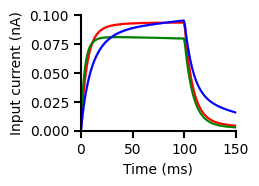

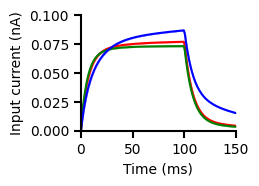

In [180]:
#plt.plot(data_same_fr["morph_1"]["radial_means_mean"][0,:,0])
#plt.plot(data_same_fr["morph_2"]["radial_means_mean"][0,:,0])
#plt.plot(data_same_fr["no_morph"]["radial_means_mean"][0,:,0])
#plt.show()
for ylabel, d,ymax in zip(["Input current (nA)"],[data_I_same_fr],[0.1,80]):
    colors = ['r','g','b']
    for j in range(2):
        plt.figure(figsize=(2,1.5))
        plt.xlabel("Time (ms)")
        plt.ylabel(ylabel)
        for i,k in enumerate(d.keys()):
            mean, sem = d[k]["radial_means_mean"][j, :, 0], d[k]["radial_means_sem"][j, :, 0]
            t = np.linspace(0,150,len(mean))
            plt.plot(t,mean,color=colors[i],lw=1.5)
            plt.fill_between(t, mean - sem, mean + sem, 
                             alpha=0.3, label="_nolegend_",color=colors[i])
            #plt.legend(labels=["Morphology 1","Morphology 2","No morphology"])
            plt.xticks([0,50,100,150])
            plt.yticks(np.linspace(0,ymax,5))
            plt.xlim(0,150)
            plt.ylim(0,ymax)
            plt.gca().spines[['top','right']].set_visible(False)
            plt.gca().spines[['left','bottom']].set_linewidth(1.5)
            plt.gca().tick_params(size=5, width=1.5)
        plt.show()

morph_1
morph_2
no_morph


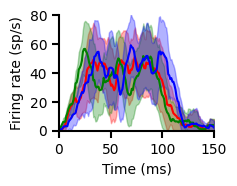

morph_1
morph_2
no_morph


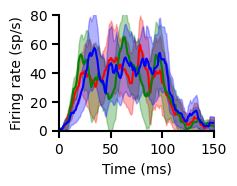

In [215]:
for ylabel, d,ymax in zip(["Firing rate (sp/s)"],[data_same_fr],[80]):
    colors = ['r','g','b']
    for j in range(2):
        plt.figure(figsize=(2,1.5))
        plt.xlabel("Time (ms)")
        plt.ylabel(ylabel)
        for i,k in enumerate(d.keys()):
            print(k)
            sem = np.array([[radial_mean(data_same_fr[k]["A"][ii,:,kk,:,:].std(axis=0) / np.sqrt(n_trials), array_width // s_res) for kk in range(data_same_fr[k]["A"].shape[2])] for ii in range(data_same_fr[k]["A"].shape[0])])[j,:,0]
            window_size = 10
            sem = scipy.ndimage.uniform_filter1d(sem, size=window_size, mode='constant')
            mean = d[k]["radial_means_mean"][j, :, 0]
            mean = scipy.ndimage.uniform_filter1d(mean, size=window_size, mode='constant')

            t = np.linspace(0,150,len(mean))
            plt.plot(t,mean,color=colors[i],lw=1.5)
            plt.fill_between(t, mean - sem, mean + sem, 
                             alpha=0.3, label="_nolegend_",color=colors[i])
            #plt.legend(labels=["Morphology 1","Morphology 2","No morphology"])
            plt.xticks([0,50,100,150])
            plt.yticks(np.linspace(0,ymax,5))
            plt.xlim(0,150)
            plt.ylim(0,ymax)
            plt.gca().spines[['top','right']].set_visible(False)
            plt.gca().spines[['left','bottom']].set_linewidth(1.5)
            plt.gca().tick_params(size=5, width=1.5)
        plt.show()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1400x300 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y same_fr_I.mp4


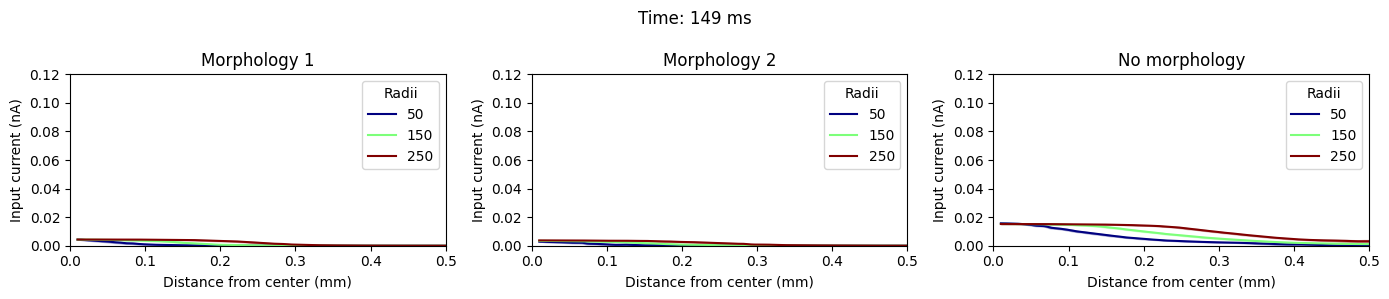

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def plot_fr_video(mean,sem,x,ax,title="",ylabel="",ymax=np.inf):
    radii = [50,150,250]
    colors = [plt.get_cmap("jet")(i / (len(radii) - 1)) for i in range(len(radii))]
    
    # Initial plot setup
    I_mean, I_sem = [mean[i, 0, :] for i in range(len(radii))], [sem[i, 0, :] for i in range(len(radii))]
    lines = [ax.plot(x, I_mean[i], color=colors[i])[0] for i in range(len(radii))]
    fill_betweens = [ax.fill_between(x, I_mean[i] - I_sem[i], I_mean[i] + I_sem[i], alpha=0.3, label="_nolegend_", color=colors[i]) for i in range(len(radii))]
    
    ax.set_title(title)
    ax.set_xlabel("Distance from center (mm)")
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, 0.5)
    ax.set_ylim(0,ymax)
    ax.legend(labels=radii, title="Radii")
    
    def update(frame):
        for i in range(len(radii)):
            I_mean, I_sem = mean[i, frame, :], sem[i, frame, :]
            lines[i].set_ydata(I_mean)
            fill_betweens[i].remove()
            fill_betweens[i] = ax.fill_between(x, I_mean - I_sem, I_mean + I_sem, alpha=0.3, label="_nolegend_", color=colors[i])

        return lines + [b for b in fill_betweens]
    
    return update, lines, fill_betweens

def plot_video_full(data_dict,x,filename,ylabel="",ymax=np.inf,t_res=50):
    # Create the figure and subplots
    fig, ax = plt.subplots(1, 3, figsize=(14, 3))
    plt.subplots_adjust(wspace=0.3)
    
    # Initialize the animations
    
    anim1 = plot_fr_video(data_dict["morph_1"]["radial_means_mean"],data_dict["morph_1"]["radial_means_sem"],x,ax[0],"Morphology 1",ylabel,ymax)
    anim2 = plot_fr_video(data_dict["morph_2"]["radial_means_mean"],data_dict["morph_2"]["radial_means_sem"],x,ax[1],"Morphology 2",ylabel,ymax)
    anim3 = plot_fr_video(data_dict["no_morph"]["radial_means_mean"],data_dict["no_morph"]["radial_means_sem"],x,ax[2],"No morphology",ylabel,ymax)
    
    # Define the update function that updates all subplots in parallel
    def update_all(frame):
        color = 'red' if frame < 100 // t_res else 'black'
        fig.suptitle(f"Time: {frame * t_res} ms",color=color)#,y=1.05,fontsize=14)
        anim1[0](frame)
        anim2[0](frame)
        anim3[0](frame)
        return (anim1[1] + [b for b in anim1[2]]) + \
               (anim2[1] + [b for b in anim2[2]]) + \
               (anim3[1] + [b for b in anim3[2]])
    
    # Create the animation
    anim = FuncAnimation(fig, update_all, frames=data_dict["morph_1"]["radial_means_mean"].shape[1], interval=50 * t_res, blit=True)
    plt.tight_layout()
    # To save the animation as a video file, use:
    anim.save(filename, writer='ffmpeg')
    plt.show()

plot_video_full(data_I_same_fr,r_fine,"same_fr_I.mp4",ylabel="Input current (nA)",ymax=0.12,t_res=1)

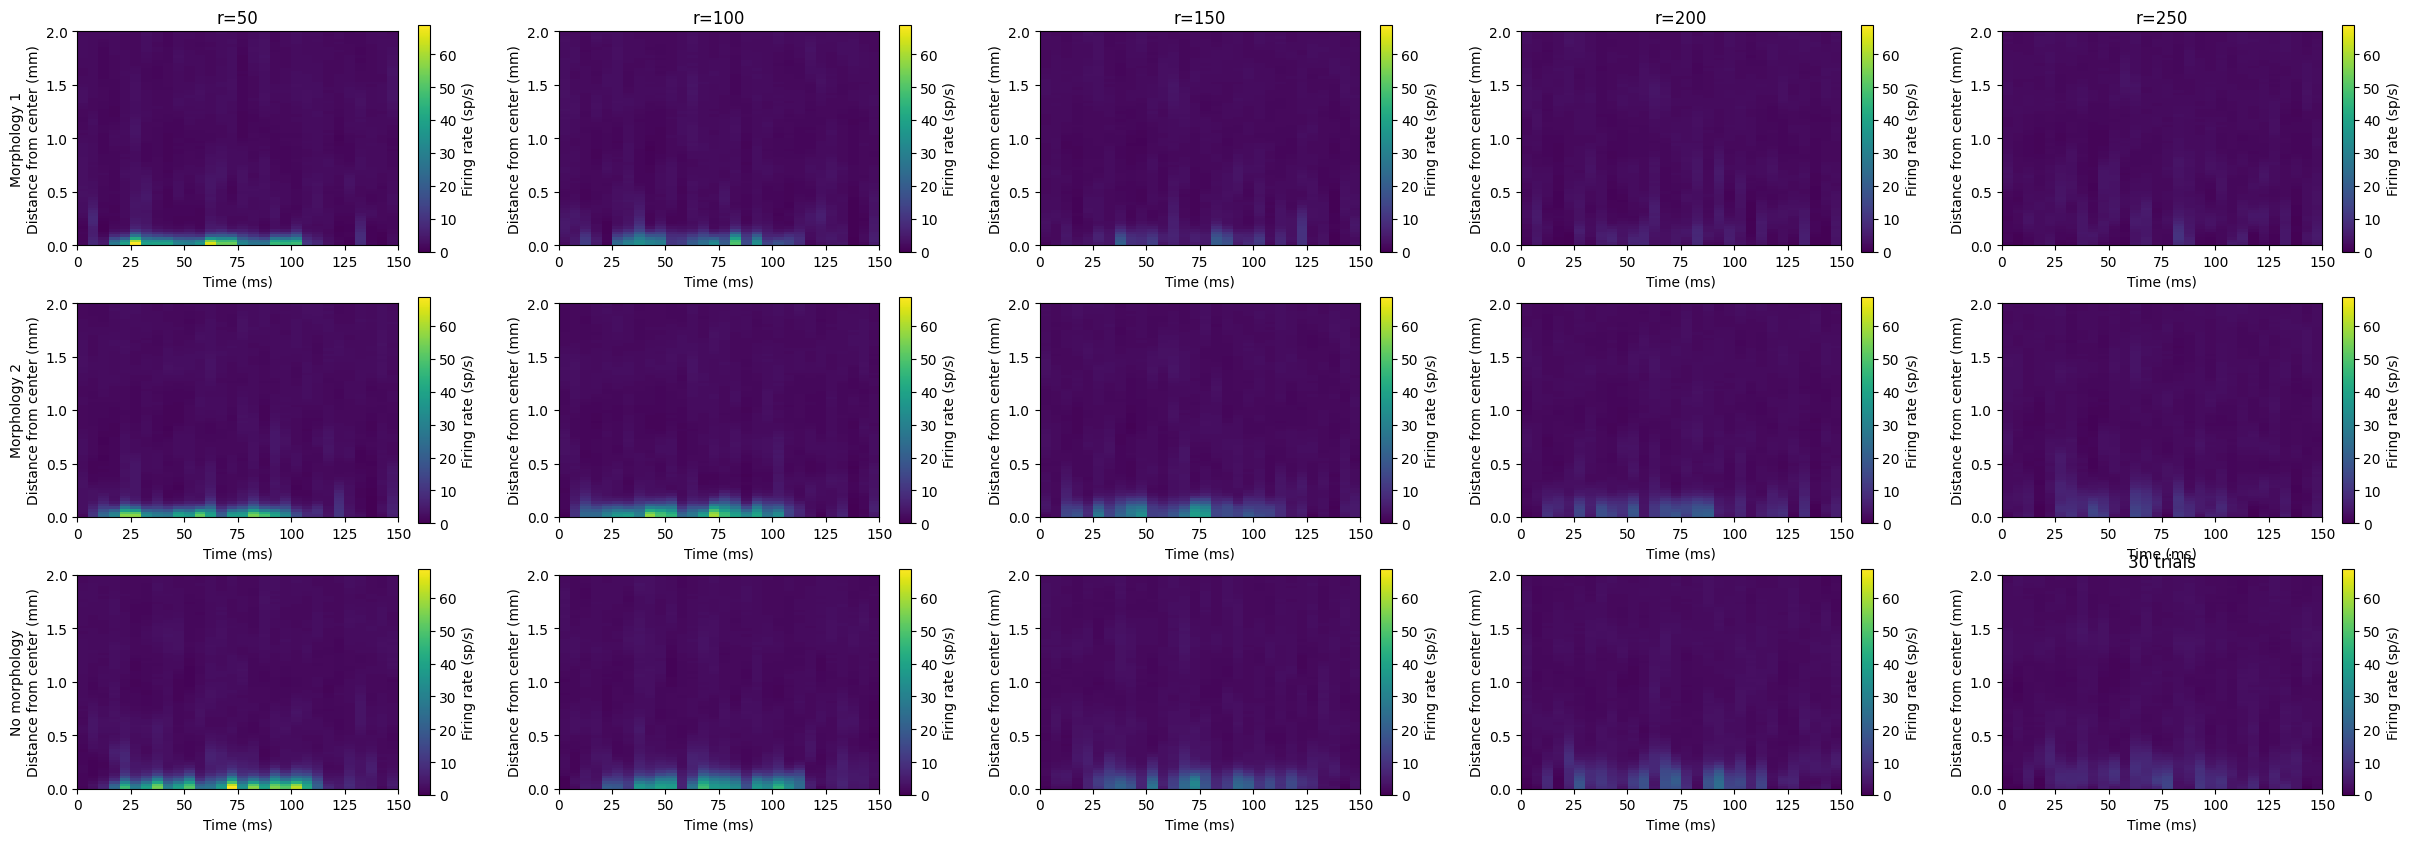

In [221]:
fig, ax = plt.subplots(3,len(radii),figsize=(30,10))
plt.subplots_adjust(wspace=0.2,hspace=0.2)
plt.title("30 trials")
vmax = np.max(np.array(rmm))
for i in range(3):
    for j in range(len(radii)):
        ax[0,j].set_title("r=%d" % radii[j])
        im = ax[i,j].imshow(np.flip(rmm[i][j,...].T,axis=0),extent=(0,radial_means_morph.shape[-2]*t_res,0,2),vmin=0,vmax=vmax,aspect=50,interpolation='none')
        ax[i,j].set_xlabel("Time (ms)")
        ylabel = "Distance from center (mm)"
        if j == 0:
            ylabel = names[i] + "\n" + ylabel
        ax[i,j].set_ylabel(ylabel)
        plt.colorbar(im,label="Firing rate (sp/s)",ax=ax[i,j])
plt.show()

In [195]:
import matplotlib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

As = [A_morph_1,A_morph_2,A_no_morph]
for j in (2):
    for i in range(len(radii)):
        fig = plt.figure(figsize=(5,5))
        A = As[j][i,:,j,:,:].mean(axis=1)
        im = plt.imshow(A[0,:,:],cmap='viridis',vmin=A.min(),vmax=A.max(),extent=(-2,2,-2,2))
        plt.xlabel("x (mm)")
        plt.ylabel("y (mm)")
        plt.xticks([-2,0,2])
        plt.yticks([-2,0,2])
        
        def animate(i):
            im.set_data(A[i,:,:])
        
        ani = matplotlib.animation.FuncAnimation(fig, animate, frames=A.shape[0],interval=t_res)
        HTML(ani.to_jshtml())
        break
    break

#ani.save("central_stimulation_morphology_%d_r=%d.gif", writer="pillow", fps=1000 / t_res * 4)

TypeError: 'int' object is not iterable

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


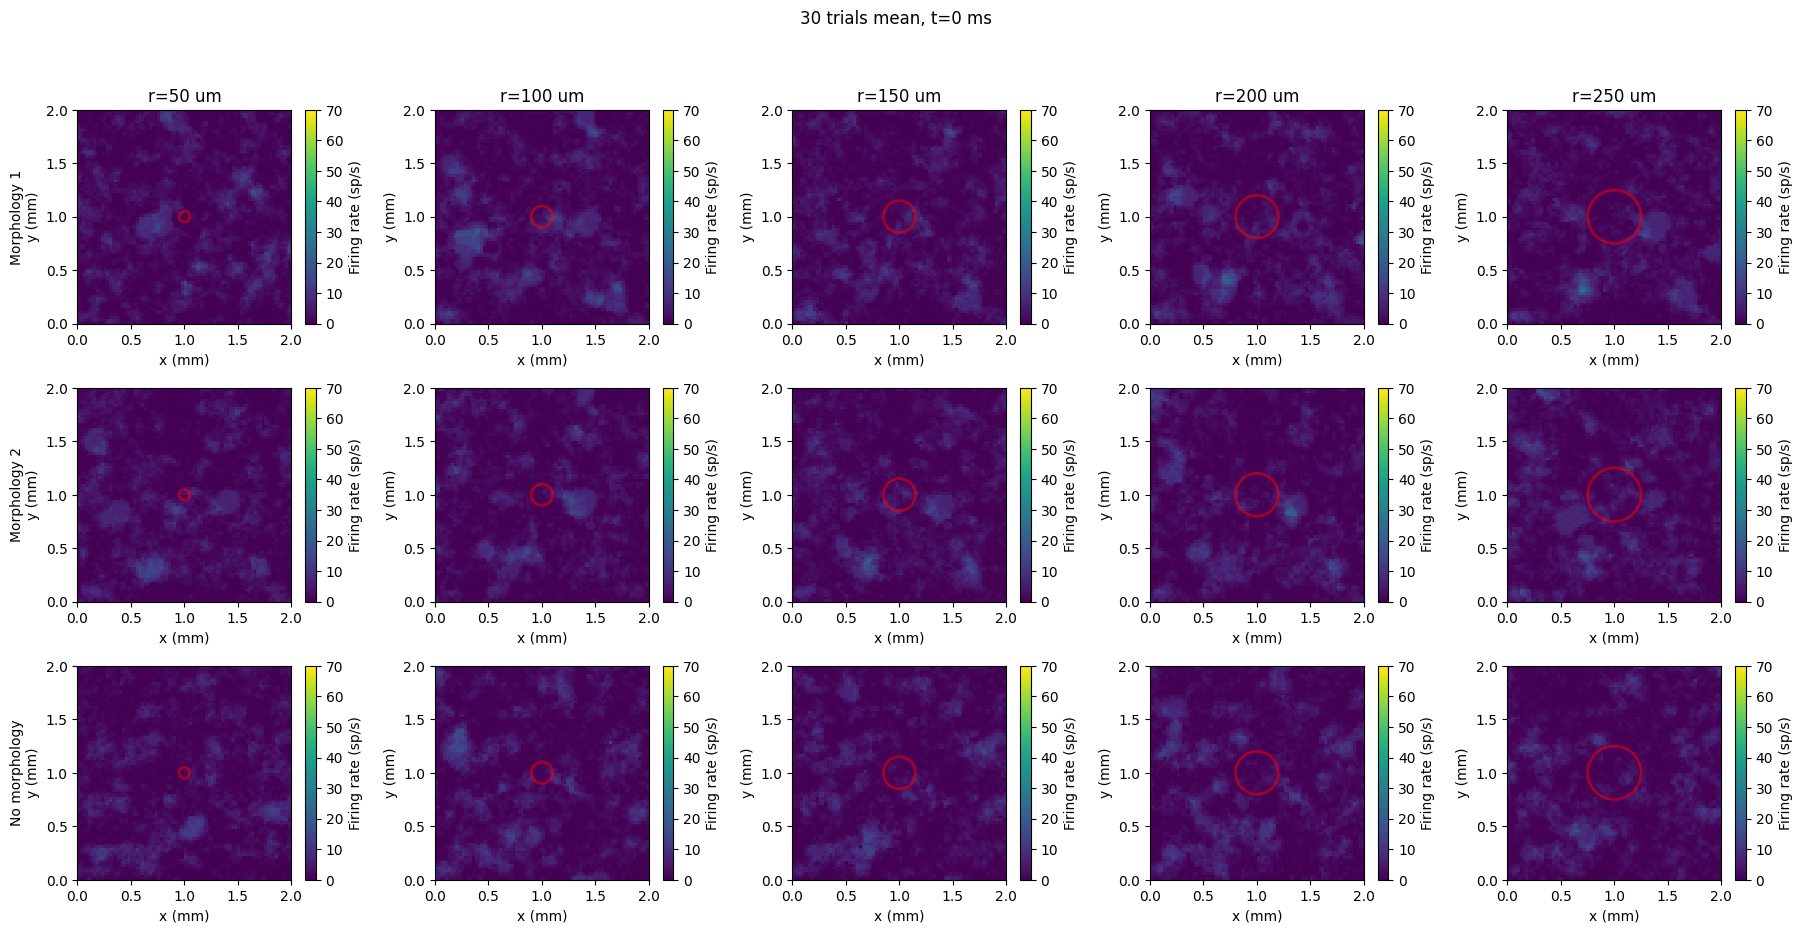

In [260]:
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
from IPython.display import HTML

# 3 x radii x trials x time x space x space
A = np.array([A_morph_1, A_morph_2, A_no_morph])
A_plot = A.mean(axis=2)
fig, ax = plt.subplots(3, len(radii), figsize=(22, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle("30 trials mean, t=0 ms")
ims = [[None for i in range(len(radii))] for i in range(3)]
circles = [[None for i in range(len(radii))] for i in range(3)]
norm = True
for i in range(3):
    for j in range(len(radii)):
        vmax = A_plot.max() if norm else A_plot[i, j, ...].max()
        ax[0, j].set_title(f"r={radii[j]} um")
        ims[i][j] = ax[i, j].imshow(A_plot[i, j, 0, :, :], extent=(0, 2, 0, 2), vmin=0, vmax=vmax, interpolation='none')
        ax[i, j].set_xlabel("x (mm)")
        ylabel = "y (mm)"
        if j == 0:
            ylabel = names[i] + "\n" + ylabel
        ax[i, j].set_ylabel(ylabel)
        plt.colorbar(ims[i][j], label="Firing rate (sp/s)", ax=ax[i, j])
        
        # Add a red hollow circle (initially invisible)
        radius_mm = radii[j] / 1000  # Convert um to mm
        circle = Circle((1, 1), radius_mm, edgecolor='red', facecolor='none', linewidth=2, visible=False,alpha=0.5)
        ax[i, j].add_patch(circle)
        circles[i][j] = circle

def animate(i):
    fig.suptitle(f"30 trials mean, t={i * t_res} ms")
    for j in range(3):
        for k in range(len(radii)):
            ims[j][k].set_data(A_plot[j, k, i, :, :])
            # Show the circle if in the time range 0:20
            if 0 <= i < 20:
                circles[j][k].set_visible(True)
            else:
                circles[j][k].set_visible(False)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=A_plot.shape[2], interval=t_res * 30)
# HTML(ani.to_jshtml())
if norm:
    ani.save("central_stimulation_trial_means_norm.gif", writer="pillow", fps=1000 / (t_res * 30))
else:
    ani.save("central_stimulation_trial_means.gif", writer="pillow", fps=1000 / (t_res * 30))

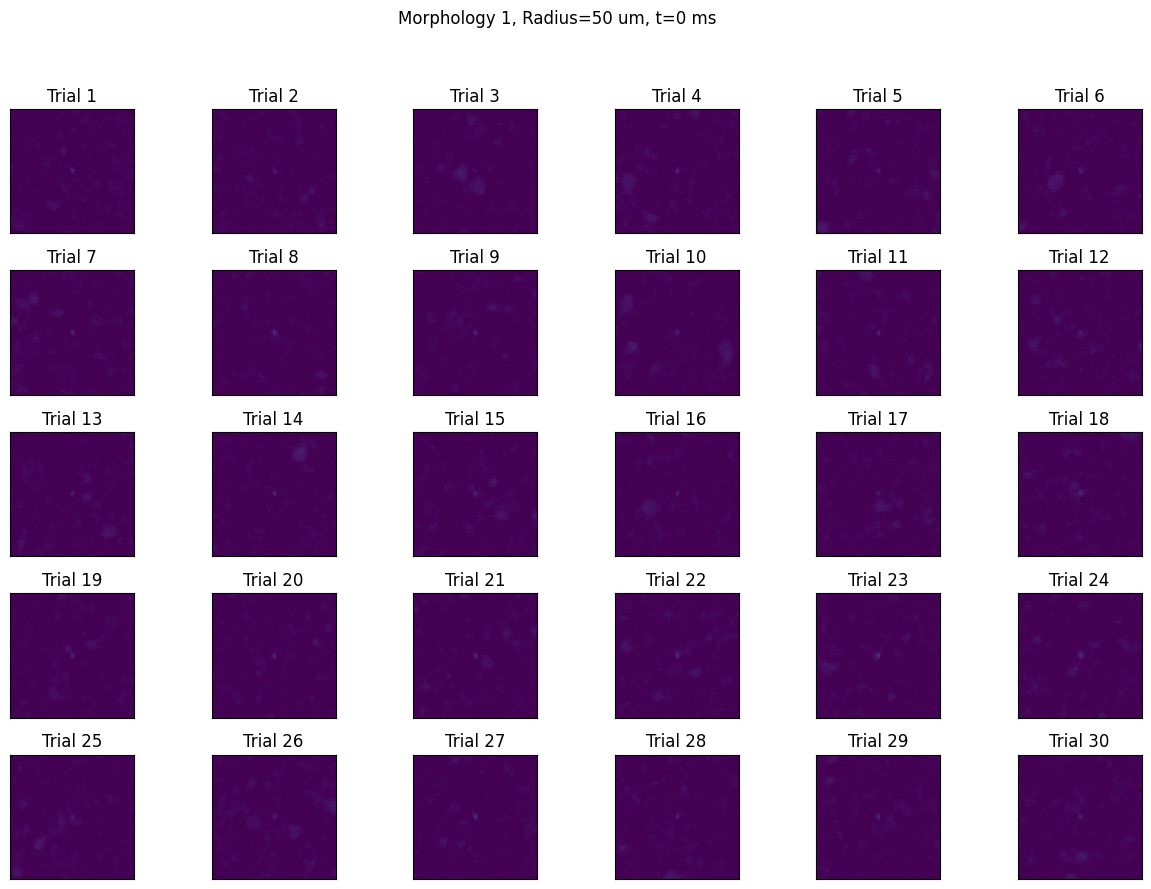

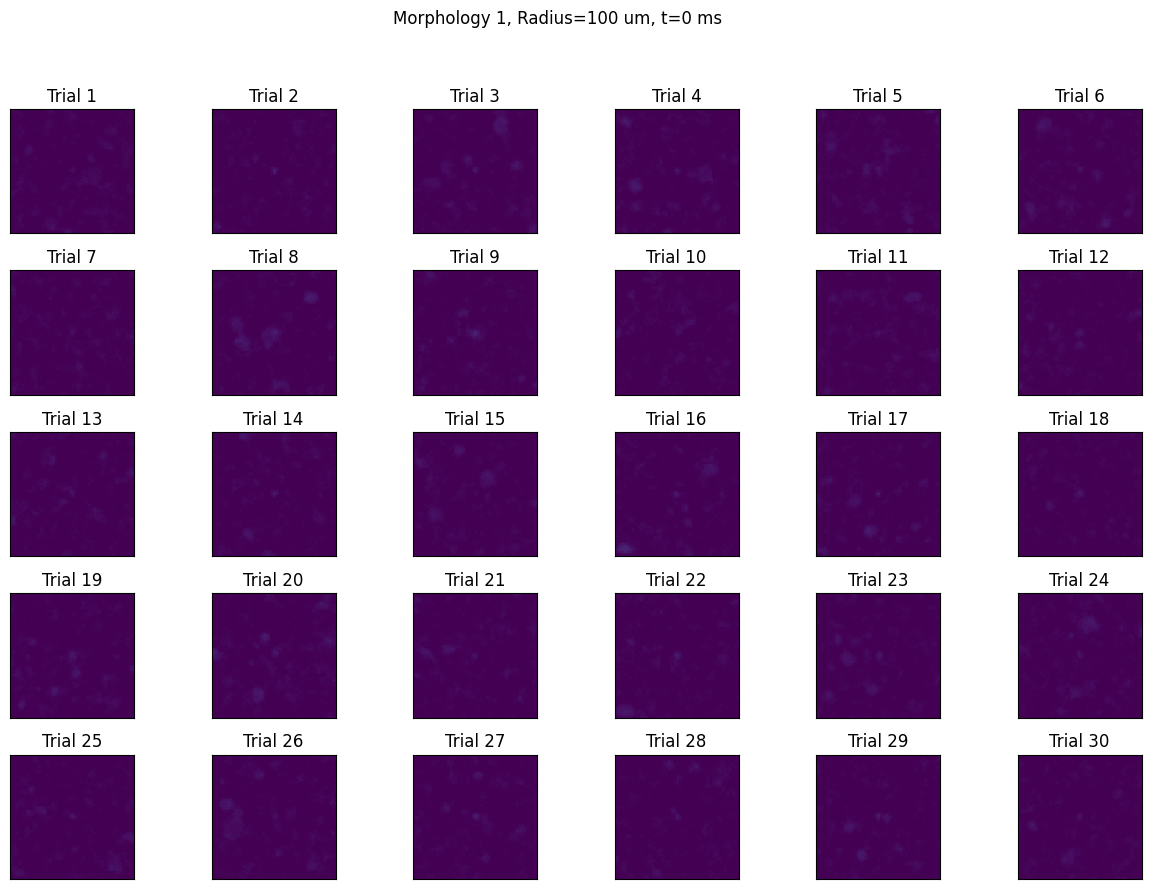

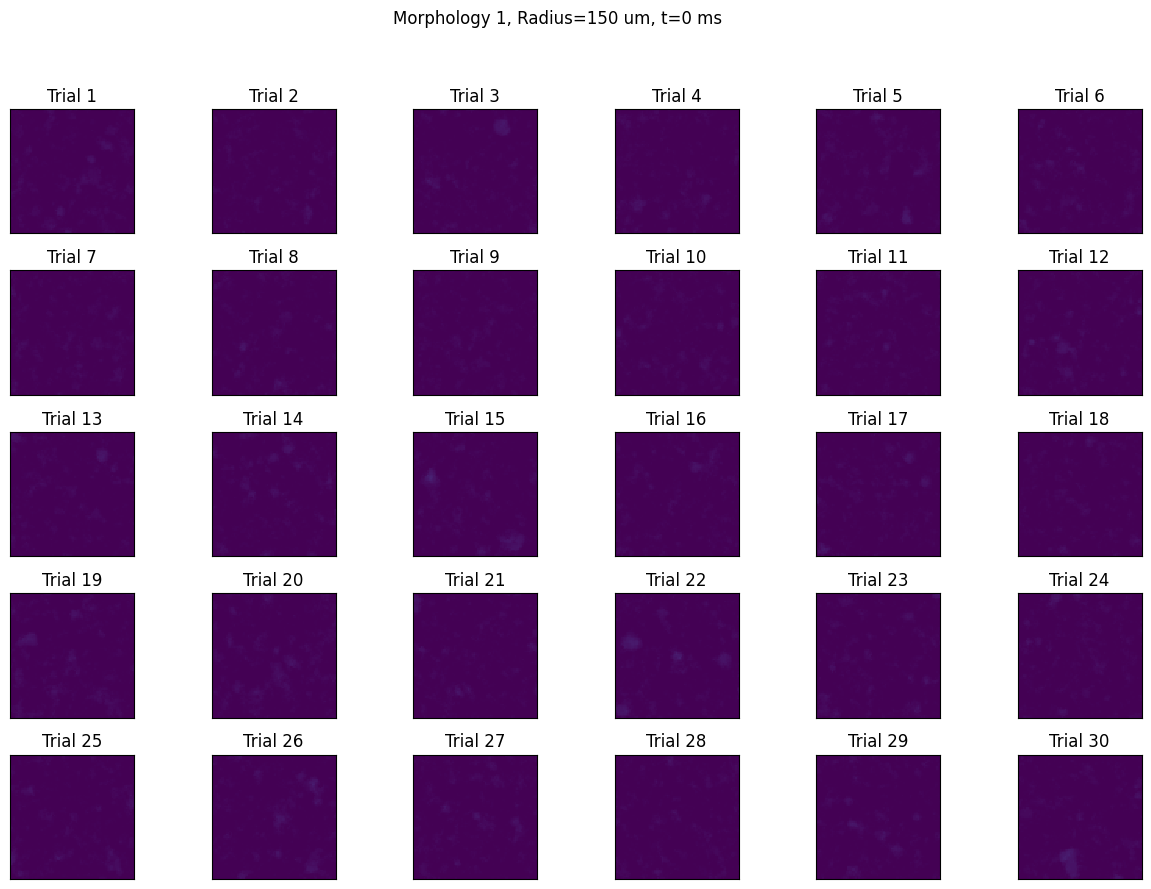

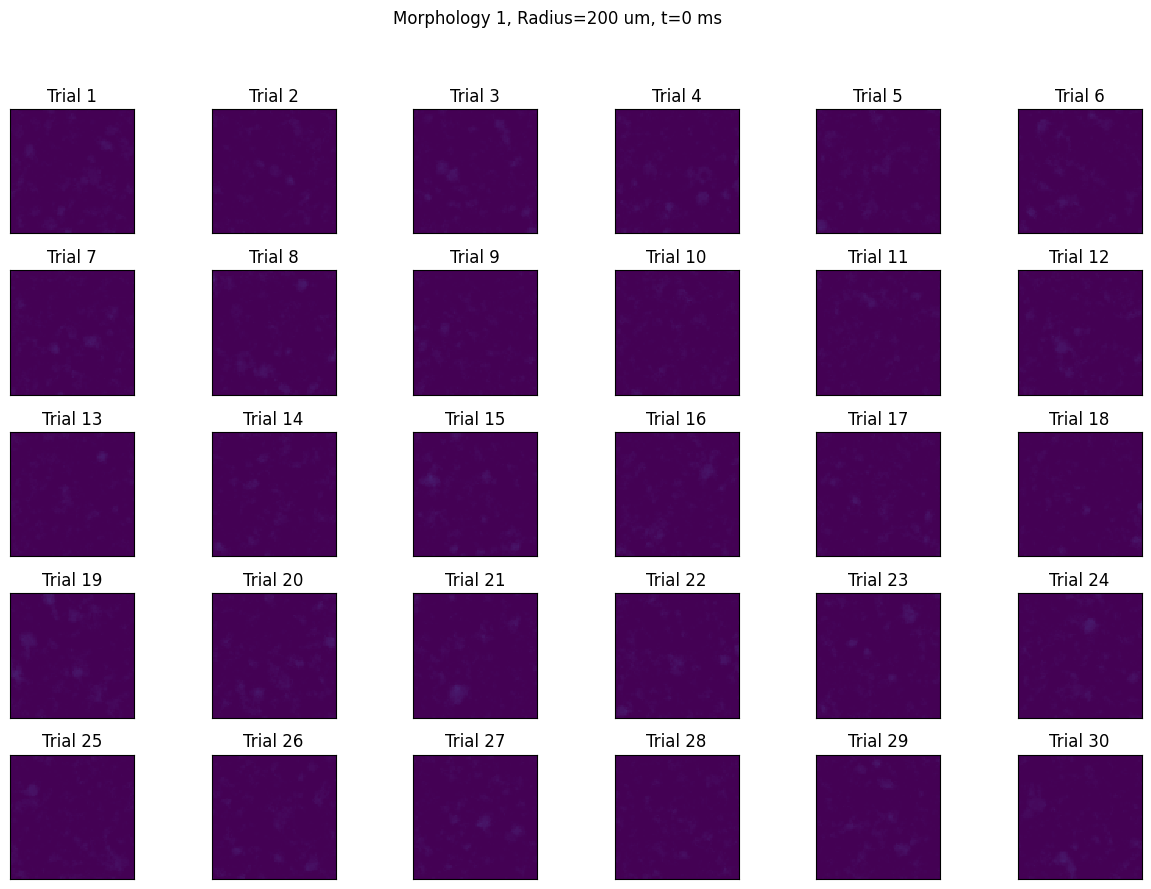

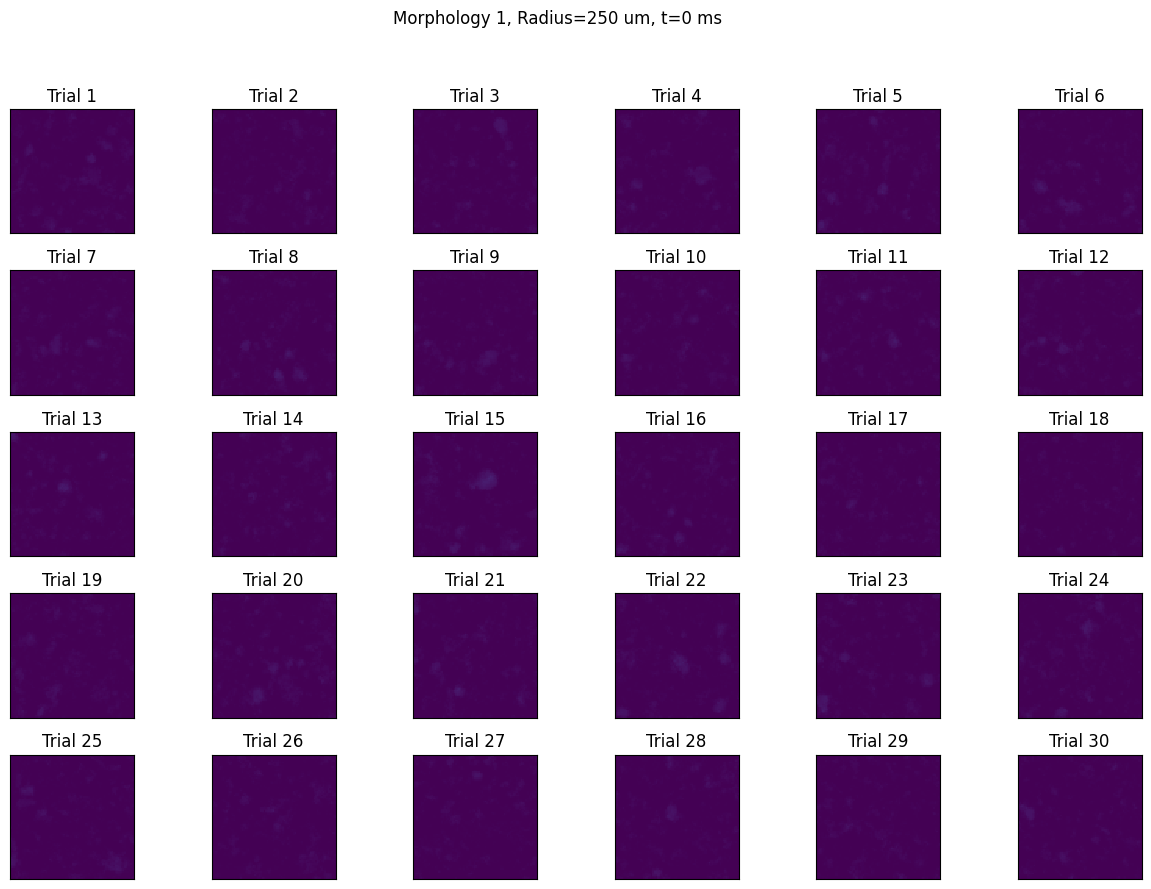

In [270]:
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# Define the trial count and subplot grid dimensions
trial_count = 30
grid_rows, grid_cols = 5, 6

# Convert data (assume A already exists as in your original code)
# Shape: 3 (morphologies) x len(radii) x trials x time x space x space
figsize = (15, 10)  # Adjust the size to fit the grid

# Iterate through morphologies and radii
for r_idx, radius in enumerate(radii):  # Radii
    for m_idx, morphology in enumerate(names):  # Morphologies
        fig, axs = plt.subplots(grid_rows, grid_cols, figsize=figsize)
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        fig.suptitle(f"{morphology}, Radius={radius} um, t=0 ms")

        ims = []
        circles = []
        
        # Initialize subplots for each trial
        for trial_idx in range(trial_count):
            row, col = divmod(trial_idx, grid_cols)
            ax = axs[row, col]
            ax.set_title(f"Trial {trial_idx + 1}")
            vmax = A[m_idx, r_idx].max()
            im = ax.imshow(A[m_idx, r_idx, trial_idx, :20, :, :].mean(axis=0), extent=(0, 2, 0, 2), 
                           vmin=0, vmax=vmax, interpolation='none')
            ax.set_xticks([])
            ax.set_yticks([])
            ims.append(im)

            # Add a red hollow circle
            radius_mm = radius / 1000  # Convert um to mm
            circle = Circle((1, 1), radius_mm, edgecolor='red', facecolor='none', linewidth=1,alpha=0.5, visible=False)
            ax.add_patch(circle)
            circles.append(circle)
        plt.show()
        break

In [265]:
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# Define the trial count and subplot grid dimensions
trial_count = 30
grid_rows, grid_cols = 5, 6

# Convert data (assume A already exists as in your original code)
# Shape: 3 (morphologies) x len(radii) x trials x time x space x space
figsize = (15, 10)  # Adjust the size to fit the grid

# Iterate through morphologies and radii
for r_idx, radius in enumerate(radii):  # Radii
    for m_idx, morphology in enumerate(names):  # Morphologies
        fig, axs = plt.subplots(grid_rows, grid_cols, figsize=figsize)
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        fig.suptitle(f"{morphology}, Radius={radius} um, t=0 ms")

        ims = []
        circles = []
        
        # Initialize subplots for each trial
        for trial_idx in range(trial_count):
            row, col = divmod(trial_idx, grid_cols)
            ax = axs[row, col]
            ax.set_title(f"Trial {trial_idx + 1}")
            vmax = A[m_idx, r_idx].max()
            im = ax.imshow(A[m_idx, r_idx, trial_idx, 0, :, :], extent=(0, 2, 0, 2), 
                           vmin=0, vmax=vmax, interpolation='none')
            ax.set_xticks([])
            ax.set_yticks([])
            ims.append(im)

            # Add a red hollow circle
            radius_mm = radius / 1000  # Convert um to mm
            circle = Circle((1, 1), radius_mm, edgecolor='red', facecolor='none', linewidth=1,alpha=0.5, visible=False)
            ax.add_patch(circle)
            circles.append(circle)

        def animate(i):
            fig.suptitle(f"{morphology}, Radius={radius} um, t={i * t_res} ms")
            for trial_idx in range(trial_count):
                ims[trial_idx].set_data(A[m_idx, r_idx, trial_idx, i, :, :])
                # Show the circle if in the time range 0:20
                if 0 <= i < 20:
                    circles[trial_idx].set_visible(True)
                else:
                    circles[trial_idx].set_visible(False)

        print(A[m_idx, r_idx].shape[1])
        ani = matplotlib.animation.FuncAnimation(fig, animate, frames=A[m_idx, r_idx].shape[1], interval=t_res * 30)
        filename = f"morphology_{m_idx}_radius_{radius}_trials.gif"
        ani.save(filename, writer="pillow", fps=1000 / (t_res * 30))
        plt.close(fig)
    raise ValueError

30
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>
30
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>
30
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


ValueError: 

In [18]:
import os
base_path = "/home/rozsa/dev/david_reduction_project/mozaik-models/LSV1M/"
search_folder = "20250317-220026[param_spont.defaults]CombinationParamSearch{trial:6}/"
paths_intensity_search = sorted([os.path.join(base_path,search_folder,d) for d in os.listdir(os.path.join(base_path,search_folder)) if os.path.isdir(os.path.join(base_path,search_folder,d))])
ds_is = [
    PickledDataStore(
        load=True,
        parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),
        replace=False,
    ) for path in paths_intensity_search
]
if 0:
    for ds in ds_is:
        RecordingArrayTimecourse(param_filter_query(ds,sheet_name="V1_Exc_L2/3"),
            ParameterSet(
                {
                    "s_res": s_res,
                    "t_res": t_res,
                    "array_width": array_width,
                    "electrode_radius": 50,
                }
            ),
        ).analyse()

In [19]:
print(param_filter_query(ds_is[5].full_datastore,st_trial=1,st_name='InternalStimulus').get_analysis_result())

(AnalogSignal
   "analysis_algorithm":'RecordingArrayTimecourse'
   "identifier":'AnalogSignal'
   "name":'AnalogSignal'
   "neuron":None
   "sheet_name":'V1_Exc_L2/3'
   "stimulus_id":'{"module_path" :"mozaik.stimuli","direct_stimulation_name":\'OpticalStimulatorArrayChR\', "direct_stimulation_parameters":MozaikExtendedParameterSet({\'size\': 800, \'spacing\': 10, \'depth_sampling_step\': 10, \'light_source_light_propagation_data\': \'light_scattering_radial_profiles_lsd10.pickle\', \'update_interval\': 1, \'stimulating_signal\': \'mozaik.sheets.direct_stimulator.stimulating_pattern_flash\', \'stimulating_signal_parameters\': {\'shape\': \'circle\', \'coords\': [[0, 0]], \'radius\': 250, \'intensity\': 0.29, \'duration\': 150, \'onset_time\': 0, \'offset_time\': 100}, \'sheet_list\': [\'V1_Exc_L2/3\'], \'sheet_intensity_scaler\': [1.0], \'sheet_transfection_proportion\': [1.0]}), "duration":150, "frame_duration":150, "name":\'InternalStimulus\', "trial":1}'
   "x_axis_name":None
   "y

In [20]:
A_is = np.array([[np.array(param_filter_query(ds.full_datastore,st_trial=j,st_name='InternalStimulus').get_analysis_result()[0].analog_signal) for j in range(n_trials)] for ds in ds_is])
radial_means_is = np.array([[radial_mean(A_is[i,:,j,:,:].mean(axis=0), array_width // s_res) for j in range(A_is.shape[2])]for i in range(A_is.shape[0])])

In [21]:
intensities = [retrieve_ds_param_values(ds, "intensity")[0] for ds in ds_is]

In [22]:
print(ParameterSet(ds_is[0].get_experiment_parametrization_list()[0][1]).stimulator_array_parameters)

{'size': 800, 'spacing': 10, 'depth_sampling_step': 10, 'light_source_light_propagation_data': 'light_scattering_radial_profiles_lsd10.pickle', 'update_interval': 1, 'stimulating_signal': 'mozaik.sheets.direct_stimulator.stimulating_pattern_flash', 'stimulating_signal_parameters': {'shape': 'circle', 'coords': [[0, 0]], 'radius': 250, 'intensity': 0.299, 'duration': 150, 'onset_time': 0, 'offset_time': 100}}


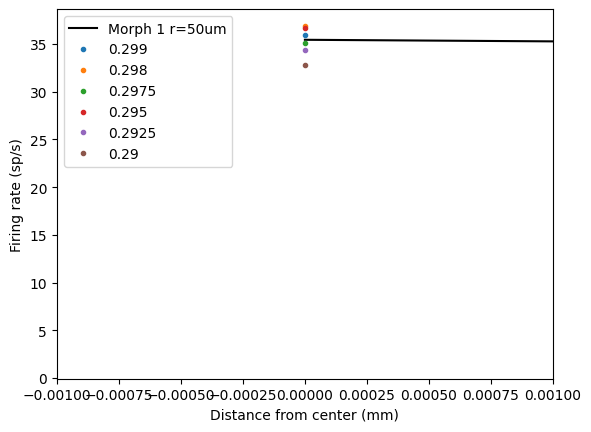

In [25]:
plt.plot(np.linspace(0,2,array_width // s_res),radial_means_morph_1[0,:100//t_res,:].mean(axis=0),'k')
thresh = 200
for i in range(radial_means_is.shape[0]):
    if intensities[i] < thresh:
        plt.plot(np.linspace(0,2,array_width // s_res),radial_means_is[i,:100//t_res,:].mean(axis=0),'.')
plt.legend(["Morph 1 r=50um"] + [inte for inte in intensities if inte < thresh])
plt.xlabel("Distance from center (mm)")
plt.ylabel("Firing rate (sp/s)")
#plt.ylim(33,38)
plt.xlim(-0.001,0.001)
plt.show()